# Splines in Python

The following code tutorial is mainly based on code provided by[Jordi Warmenhoven](https://nbviewer.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%207.ipynb). To learn {cite:p}`James2021` and Python code

## Data

### Import

In [115]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/kirenz/datasets/master/wage.csv')
df

,Unnamed: 0,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,376816,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,302281,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,10033,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,14375,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


### Create label and feature

We only use the feature age to predict wage:

In [116]:
X = df[['age']]
y = df[['wage']]

### Data split

Dividing data into train and test datasets

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

### Data exploration

Visualize the relationship between age and wage:

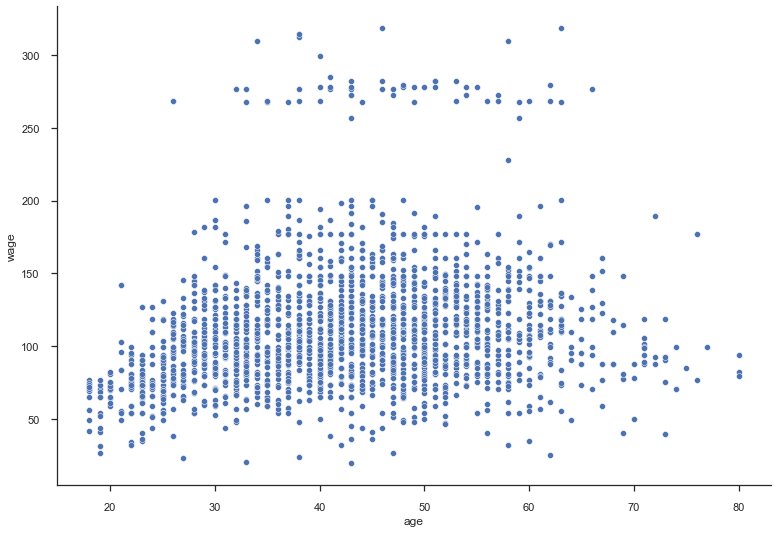

In [118]:
import seaborn as sns  

# seaborn settings
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage']);

## Simple regression

In [119]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [120]:
print(lm.coef_)
print(lm.intercept_)

[[0.72106369]]
[80.58924709]


In [121]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = lm.predict(X_train)
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = lm.predict(X_test)
rmse_test =mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results_lm = pd.DataFrame(
    {
    "model": "Linear Model (lm)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test],
    })
model_results_lm

,model,rmse_train,rmse_test
0,Linear Model (lm),40.705334,41.413848


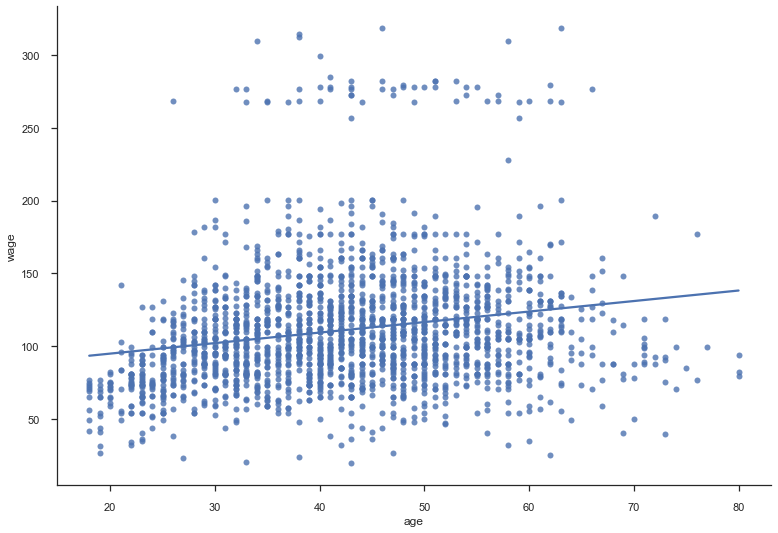

In [122]:
sns.regplot(x=X_train['age'], y=y_train['wage'], ci=None);

## Polynomial regression

In [123]:
from sklearn.preprocessing import PolynomialFeatures

# polynomial degree 2
poly = PolynomialFeatures(2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [124]:
pm = LinearRegression()
pm.fit(X_train_poly,y_train)

LinearRegression()

In [125]:
# Training data
pred_train = pm.predict(X_train_poly)
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = pm.predict(X_test_poly)
rmse_test =mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results_pm = pd.DataFrame(
    {
    "model": "Polynomial Model (pm)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test],
    })

results = pd.concat([model_results_lm, model_results_pm], axis=0)
results

,model,rmse_train,rmse_test
0,Linear Model (lm),40.705334,41.413848
0,Polynomial Model (pm),39.823165,40.344788


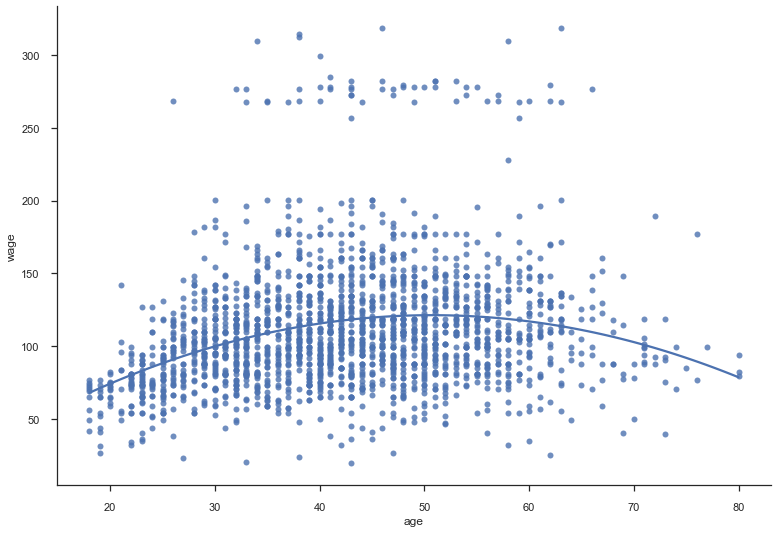

In [126]:
# plot
sns.regplot(x=X_train['age'], y=y_train['wage'], ci=None, order=2);

## Cubic spline

We use the module [patsy](https://patsy.readthedocs.io/en/latest/overview.html) to create non-linear transformations of the input data. We will fit 2 models with different number of knots.

In [127]:
from patsy import dmatrix

In [128]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix(
            "bs(train, knots=(25,40,60), degree=3, include_intercept=False)", 
                {"train": X_train},return_type='dataframe')

In [129]:
transformed_x.head()

,Intercept,"bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
1045,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
2717,1.0,0.000000,0.024796,0.477428,0.456182,0.041594,0.0
2835,1.0,0.070523,0.598567,0.319030,0.011879,0.000000,0.0
2913,1.0,0.000000,0.000272,0.241156,0.576321,0.182250,0.0
959,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0


We use statsmodels to estimate a generalized linear model:

In [130]:
import statsmodels.api as sm

In [131]:
# Fitting Generalised linear model on transformed dataset
cs = sm.GLM(y_train, transformed_x).fit()

In [132]:
# Training data
pred_train = cs.predict(dmatrix("bs(train, knots=(25,40,60), include_intercept=False)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = cs.predict(dmatrix("bs(test, knots=(25,40,60), include_intercept=False)", {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results_cs = pd.DataFrame(
    {
    "model": "Cubic spline (cs)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })
results = pd.concat([results, model_results_cs], axis=0)
results

,model,rmse_train,rmse_test
0,Linear Model (lm),40.705334,41.413848
0,Polynomial Model (pm),39.823165,40.344788
0,Cubic spline (cs),39.726084,40.267857


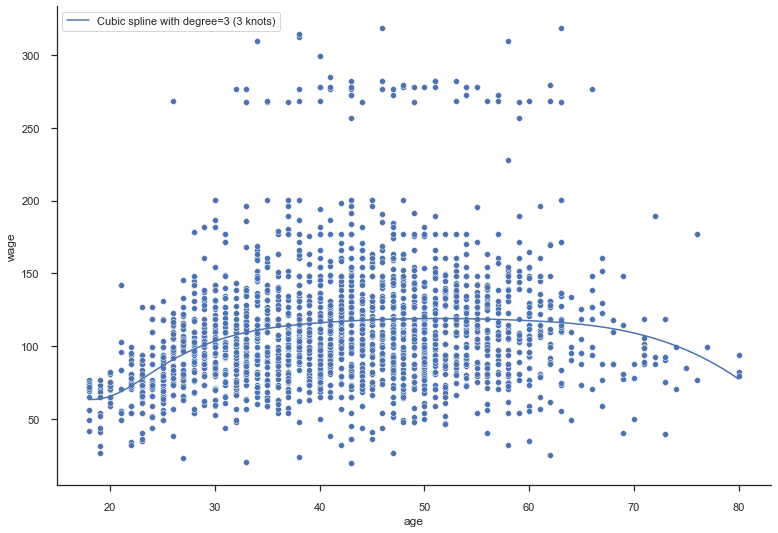

In [133]:
import numpy as np

# Create observations
xp = np.linspace(X_test.min(),X_test.max(), 100)
# Make some predictions
pred = cs.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])
plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)')
plt.legend();

## Natural cubic spline

In [134]:
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train}, return_type='dataframe')

ncs = sm.GLM(y_train, transformed_x3).fit()

In [135]:
# Training data
pred_train = ncs.predict(dmatrix("cr(train, df=3)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = ncs.predict(dmatrix("cr(test, df=3)", {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results_ncs = pd.DataFrame(
    {
    "model": "Natural cubic spline (ncs)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })

results = pd.concat([results, model_results_ncs], axis=0)
results

,model,rmse_train,rmse_test
0,Linear Model (lm),40.705334,41.413848
0,Polynomial Model (pm),39.823165,40.344788
0,Cubic spline (cs),39.726084,40.267857
0,Natural cubic spline (ncs),39.882574,40.325236


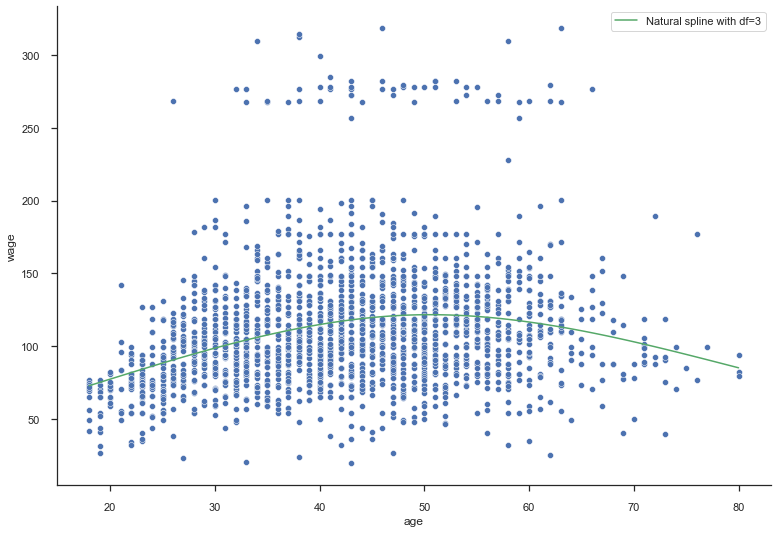

In [136]:
# Make predictions
pred = ncs.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])
plt.plot(xp, pred,color='g', label='Natural spline with df=3')
plt.legend();